# Naural Networks

## Załadowanie i przygotowanie danych

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import keras
import tensorflow
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

Wstępne załadowanie i eskploracja oryginalnych danych.

In [77]:
chess = pd.read_csv("Data/games.csv")
chess = chess.loc[:9999, :]
chess.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Zakodowanie godzin na dane z zakresu (0, 1)

https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

In [78]:
hoursAfterMidnight = (chess.loc[:, 'created_at']/1000).apply(datetime.fromtimestamp).dt.hour
chess['sin_created_at'] = np.sin(2*np.pi*hoursAfterMidnight/24)
chess['cos_created_at'] = np.cos(2*np.pi*hoursAfterMidnight/24)

Usunięcie niepotrzebnych kolumn.

In [79]:
chess.drop(columns=['created_at', 'last_move_at', 'victory_status', 'white_id', 'moves', 'black_id', 'opening_name', 'id'], inplace=True)
chess.head()

,rated,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply,sin_created_at,cos_created_at
0,False,13,white,15+2,1500,1191,D10,5,-0.500000,8.660254e-01
1,True,16,black,5+10,1322,1261,B00,4,-0.258819,9.659258e-01
2,True,61,white,5+10,1496,1500,C20,3,-0.258819,9.659258e-01
3,True,61,white,20+0,1439,1454,D02,3,-1.000000,-1.836970e-16
4,True,95,white,30+3,1523,1469,C41,5,-0.866025,5.000000e-01


Przedstawienie na wykresie liczby wygranych białych, czarnych oraz remisów

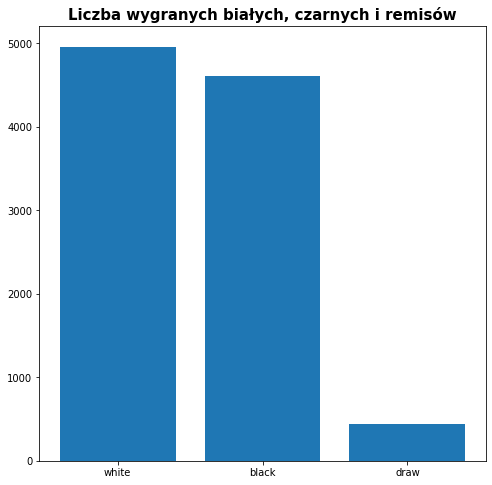

In [80]:
labels = chess.loc[:, "winner"].value_counts().index
values = chess.loc[:, "winner"].value_counts().values
plt.figure(figsize=(8, 8))
plt.bar(labels, values, align="center")
plt.title("Liczba wygranych białych, czarnych i remisów", fontdict={"fontweight": "bold", "size": 15})
plt.show()

Zamiana kolumny rated z Boolen na zero-jedynkową i zakodowanie wartości kategorycznych

In [81]:
chess.loc[:, 'rated'] = chess.loc[:, 'rated']*1
yRaw = chess.loc[:, 'winner']
temp = pd.get_dummies(chess.loc[:, ['increment_code', 'winner', 'opening_eco']])
chess.drop(columns=['increment_code', 'winner', 'opening_eco'], inplace=True)
chess = pd.concat([chess, temp], axis=1)
chess.replace({np.nan, 0})

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-5.000000e-01,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-2.588190e-01,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000e+00,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-8.660254e-01,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,63,1195,1369,5,-5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,95,1195,1369,3,1.224647e-16,-1.000000e+00,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,76,1195,1247,6,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,1,40,1369,1062,4,5.000000e-01,-8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
chess.head()

,rated,turns,white_rating,black_rating,opening_ply,sin_created_at,cos_created_at,increment_code_0+12,increment_code_0+15,increment_code_0+16,...,opening_eco_E71,opening_eco_E73,opening_eco_E76,opening_eco_E77,opening_eco_E80,opening_eco_E81,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94
0,0,13,1500,1191,5,-0.500000,8.660254e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16,1322,1261,4,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1496,1500,3,-0.258819,9.659258e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,61,1439,1454,3,-1.000000,-1.836970e-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,1523,1469,5,-0.866025,5.000000e-01,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Tworzenie modelu

Artykuł o tworzeniu modelu: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

## Próba przewidzenie czy wygra biały, czarny czy spotkanie zakończy się remisem

Podział na zmienne objąśniające i objaśnianą, oraz podział na zbiór uczący i testowy w stosunku 80/20

In [83]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = chess.loc[:, ['winner_black',	'winner_draw', 'winner_white']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Tworzenie początkowego modelu z jedną warstwą wejściową, jedną ukrytą, oraz jedną wyjściową. Tworzony model będzie typu Sekwencyjnego, czyli do modelu dodajemy kolejne warstwy neuronowe, z wybranymi przez nasa parametrami.

Dense Layer: https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/

Cross_entropy: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy

In [84]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

Optymalizacja modelu do uczenia przy uzyciu adaptującego optymalizera Adam

In [85]:
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

Fitowanie modelu

In [86]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 1s 16ms/step - loss: 7.6614 - categorical_accuracy: 0.4900
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 3.3051 - categorical_accuracy: 0.4800
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 1.6966 - categorical_accuracy: 0.4926
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 1.1753 - categorical_accuracy: 0.5537
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 1.0469 - categorical_accuracy: 0.5297
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.9028 - categorical_accuracy: 0.5458
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8642 - categorical_accuracy: 0.5540
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 0.8316 - categorical_accuracy: 0.5674
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 0.8158 - categorical_accuracy: 0.5910
Epoch 10/100
8/8

Przedstawienie accuracy dla kazdego ze 100 epchów na wykresie liniowym

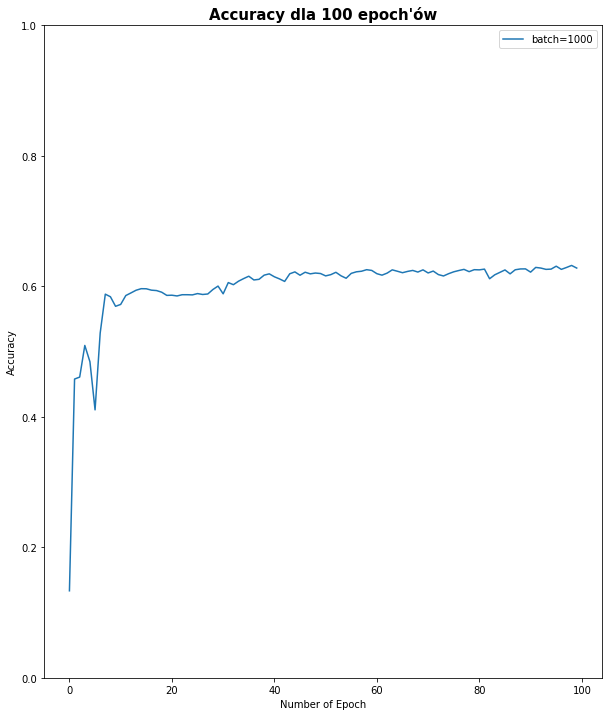

In [15]:
plt.figure(figsize=(10, 12))
plt.title("Accuracy dla 100 epoch'ów", fontdict={"fontweight": "bold", "size": 15})
plt.ylabel("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylim(0, 1)
plt.plot(batch1000.history['categorical_accuracy'], label="batch=1000")
plt.legend()

Artykuł o optymalizacji: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

Funkcja straty: https://www.brutalk.com/pl/wiadomosci/brutalk-blog/przeglad/funkcje-strat-i-strat-do-szkolenia-sieci-neuronowych-uczenia-glebokiego-6046fa42120e8

Artykuł o funkcjach aktywacyjnych: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

Categorical accuracy: https://towardsdatascience.com/keras-accuracy-metrics-8572eb479ec7

### model evaluation

In [16]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.7392 - categorical_accuracy: 0.6325


[0.7392409443855286, 0.6324999928474426]

## Próba przewidzenie czy wygra biały


In [17]:
yWhite = y.loc[:, 'winner_white']
X_train, X_test, y_train, y_test = train_test_split(X, yWhite, test_size=0.2)

In [18]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='softmax'))

In [19]:
opt = keras.optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

In [20]:
batch1000 = model.fit(X_train, y_train, epochs=100, batch_size=1000, use_multiprocessing=True)

Epoch 1/100
8/8 [==============================] - 1s 7ms/step - loss: 7.6578 - binary_accuracy: 0.4983
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 2.6207 - binary_accuracy: 0.4983
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 1.3690 - binary_accuracy: 0.4983
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 1.0055 - binary_accuracy: 0.4983
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.7995 - binary_accuracy: 0.4983
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7056 - binary_accuracy: 0.4983
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6568 - binary_accuracy: 0.4983
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.6393 - binary_accuracy: 0.4983
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6350 - binary_accuracy: 0.4983
Epoch 10/100
8/8 [==============================] - 0s 5ms/step 

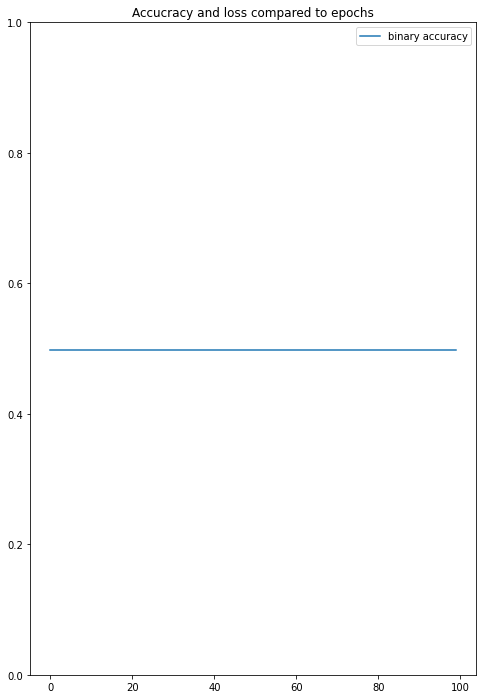

In [21]:
plt.figure(figsize=(8,12))
# plt.plot(batch1000.history['loss'], label="loss")
plt.plot(batch1000.history['binary_accuracy'], label="binary accuracy")
plt.title("Accucracy and loss compared to epochs")
plt.ylim(0, 1)
plt.legend()

In [22]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.6467 - binary_accuracy: 0.4870


[0.6466948986053467, 0.4869999885559082]

Wynik gorszy od początkowego modelu

## Skuteczność modelu w zależności od liczby warstw neuronów i zmian hiperparametrów

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [89]:
X = chess.drop(columns=['winner_black',	'winner_draw', 'winner_white'])
y = yRaw.replace({"white": 0, "black": 1, "draw": 2})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
def build_clf(unit):
    model = Sequential()
    model.add(Dense(units=unit, input_dim=634, activation='relu'))
    model.add(Dense(units=unit, activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

### GridSearch sprawdzanie epochs i batch size.

In [91]:
model = KerasClassifier(build_fn=build_clf)

params= {"epochs": list(range(20, 120, 40)), 
        "batch_size": [100, 500, 1000, 2000],
        "unit": [8, 16]}

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

/var/folders/6v/9h3mqcyj2ylfrpgzflt3jn2r0000gn/T/ipykernel_51727/1795005770.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [106]:
grid_result = grid.fit(X_train, y_train)

2022-05-28 20:09:16.905764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 20:09:16.905717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-28 20:09:16.905901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
64/64 [==============================] - 2s 6ms/step - loss: 35.0119 - accuracy: 0.3745
Epoch 2/20
64/64 [==============================] - 2s 6ms/step - loss: 3.4154 - accuracy: 0.4523
Epoch 2/20
64/64 [==============================] - 2s 6ms/step - loss: 28.2557 - accuracy: 0.4306
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.9376 - accuracy: 0.6130
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 2.2006 - accuracy: 0.5930
Epoch 3/20
64/64 [==============================] - 0s 8ms/step - loss: 0.8302 - accuracy: 0.5859
Epoch 3/20
64/64 [==============================] - 1s 8ms/step - loss: 3.5884 - accuracy: 0.5938
Epoch 3/20
64/64 [==============================] - 0s 7ms/step - loss: 0.8269 - accuracy: 0.6186
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 1.7318 - accuracy: 0.5959
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 0.7915 - ac

=========================] - 0s 9ms/step - loss: 1.2655 - accuracy: 0.6044
Epoch 8/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7678 - accuracy: 0.6137
Epoch 74/100
7/7 [==============================] - 0s 10ms/step - loss: 5.7491 - accuracy: 0.1452
Epoch 9/20
7/7 [==============================] - 0s 7ms/step - loss: 1.1962 - accuracy: 0.6066
Epoch 9/20
7/7 [==============================] - 1s 89ms/step - loss: 1.1192 - accuracy: 0.6009
Epoch 10/20
Epoch 75/100
Epoch 10/20
7/7 [==============================] - 0s 15ms/step - loss: 1.0630 - accuracy: 0.6058
Epoch 11/20
Epoch 11/20
13/13 [==============================] - 0s 12ms/step - loss: 0.7590 - accuracy: 0.6248
Epoch 76/100
7/7 [==============================] - 0s 10ms/step - loss: 0.9575 - accuracy: 0.5005
Epoch 12/20
7/7 [==============================] - 0s 11ms/step - loss: 1.0134 - accuracy: 0.6059
Epoch 12/20
7/7 [==============================] - 0s 12ms/step - loss: 0.9726 - accuracy: 0.6084
Epoch

 - loss: 0.7353 - accuracy: 0.6413
7/7 [==============================] - 0s 9ms/step - loss: 0.8650 - accuracy: 0.5355
Epoch 78/100
Epoch 15/20
7/7 [==============================] - 0s 9ms/step - loss: 0.8736 - accuracy: 0.6097
Epoch 16/20
Epoch 16/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7359 - accuracy: 0.6466
Epoch 79/100
7/7 [==============================] - 0s 7ms/step - loss: 0.8360 - accuracy: 0.5555
Epoch 17/20
7/7 [==============================] - 0s 9ms/step - loss: 0.8862 - accuracy: 0.6005
Epoch 17/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8310 - accuracy: 0.6137
Epoch 18/20
Epoch 18/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8203 - accuracy: 0.5723
Epoch 19/20
7/7 [==============================] - 0s 9ms/step - loss: 0.8090 - accuracy: 0.6228
Epoch 19/20
13/13 [==============================] - 0s 5ms/step - loss: 0.7348 - accuracy: 0.6497
Epoch 81/100
7/7 [==============================] - 0s 8ms/ste

7/7 [==============================] - 0s 6ms/step - loss: 0.7609 - accuracy: 0.6286
Epoch 35/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7604 - accuracy: 0.6267
Epoch 36/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7611 - accuracy: 0.6233
Epoch 37/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7583 - accuracy: 0.6311
Epoch 38/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7574 - accuracy: 0.6272
Epoch 39/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7571 - accuracy: 0.6248
Epoch 40/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7571 - accuracy: 0.6269
Epoch 41/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7573 - accuracy: 0.6255
Epoch 42/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7563 - accuracy: 0.6298
Epoch 43/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7597 - accuracy: 0.6261
Epoch 44/60
7/7 [=========================

: 0.6263
Epoch 23/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7941 - accuracy: 0.6198
Epoch 31/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7674 - accuracy: 0.6277
Epoch 24/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7936 - accuracy: 0.6181
Epoch 32/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7658 - accuracy: 0.6306
Epoch 25/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7929 - accuracy: 0.6220
Epoch 33/60
7/7 [==============================] - 0s 5ms/step - loss: 0.7657 - accuracy: 0.6342
Epoch 26/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7919 - accuracy: 0.6195
Epoch 34/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7724 - accuracy: 0.6214
Epoch 27/60
7/7 [==============================] - 0s 6ms/step - loss: 0.7910 - accuracy: 0.6195
Epoch 35/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7653 - accuracy: 0.6292
Epoch 28/60
7/7 [====

7/7 [==============================] - 1s 7ms/step - loss: 56.1236 - accuracy: 0.4964
Epoch 2/60
7/7 [==============================] - 0s 5ms/step - loss: 48.1384 - accuracy: 0.4964
Epoch 3/60
7/7 [==============================] - 0s 5ms/step - loss: 40.8271 - accuracy: 0.4964
Epoch 4/60
7/7 [==============================] - 0s 6ms/step - loss: 34.1772 - accuracy: 0.4964
Epoch 5/60
7/7 [==============================] - 0s 21ms/step - loss: 28.1658 - accuracy: 0.4964
Epoch 6/60
7/7 [==============================] - 0s 5ms/step - loss: 22.7434 - accuracy: 0.4964
Epoch 7/60
7/7 [==============================] - 0s 9ms/step - loss: 17.8541 - accuracy: 0.4964
Epoch 8/60
7/7 [==============================] - 0s 5ms/step - loss: 13.4284 - accuracy: 0.4964
Epoch 9/60
7/7 [==============================] - 0s 11ms/step - loss: 9.3848 - accuracy: 0.4964
Epoch 10/60
7/7 [==============================] - 0s 5ms/step - loss: 5.6737 - accuracy: 0.4966
Epoch 11/60
7/7 [=======================

Epoch 42/60
7/7 [==============================] - 0s 14ms/step - loss: 0.7695 - accuracy: 0.6273
Epoch 36/60
7/7 [==============================] - 0s 7ms/step - loss: 0.7969 - accuracy: 0.6306
Epoch 43/60
7/7 [==============================] - 0s 9ms/step - loss: 0.7693 - accuracy: 0.6283
Epoch 37/60
7/7 [==============================] - 0s 10ms/step - loss: 0.7949 - accuracy: 0.6323
Epoch 44/60
7/7 [==============================] - 0s 8ms/step - loss: 0.7706 - accuracy: 0.6247
Epoch 38/60
7/7 [==============================] - 0s 9ms/step - loss: 0.7873 - accuracy: 0.6328
Epoch 45/60
7/7 [==============================] - 0s 10ms/step - loss: 0.7680 - accuracy: 0.6306
Epoch 39/60
7/7 [==============================] - 0s 9ms/step - loss: 0.7815 - accuracy: 0.6392
Epoch 46/60
7/7 [==============================] - 0s 10ms/step - loss: 0.7660 - accuracy: 0.6320
Epoch 40/60
7/7 [==============================] - 0s 9ms/step - loss: 0.7910 - accuracy: 0.6289
Epoch 47/60
7/7 [=========

7/7 [==============================] - 2s 16ms/step - loss: 31.9174 - accuracy: 0.4663
Epoch 2/60
7/7 [==============================] - 0s 5ms/step - loss: 6.4704 - accuracy: 0.5006
Epoch 3/60
7/7 [==============================] - 0s 5ms/step - loss: 4.4322 - accuracy: 0.5389
Epoch 4/60
Epoch 1/60
7/7 [==============================] - 0s 11ms/step - loss: 3.4267 - accuracy: 0.5069
Epoch 5/60
7/7 [==============================] - 0s 10ms/step - loss: 2.2410 - accuracy: 0.5883
Epoch 6/60
7/7 [==============================] - 0s 8ms/step - loss: 2.1224 - accuracy: 0.6158
Epoch 7/60
7/7 [==============================] - 0s 11ms/step - loss: 1.7319 - accuracy: 0.5867
Epoch 8/60
7/7 [==============================] - 2s 10ms/step - loss: 46.4058 - accuracy: 0.0400
Epoch 2/60
7/7 [==============================] - 0s 11ms/step - loss: 1.4989 - accuracy: 0.5580
Epoch 9/60
7/7 [==============================] - 0s 9ms/step - loss: 14.8930 - accuracy: 0.3392
Epoch 3/60
7/7 [===============

7/7 [==============================] - 0s 11ms/step - loss: 0.8746 - accuracy: 0.6095
Epoch 18/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8878 - accuracy: 0.4717
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8475 - accuracy: 0.5252
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 0.8654 - accuracy: 0.6098
Epoch 19/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8318 - accuracy: 0.6016
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.8592 - accuracy: 0.6047
Epoch 20/60
7/7 [==============================] - 0s 8ms/step - loss: 0.8228 - accuracy: 0.6203
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.8508 - accuracy: 0.6084
Epoch 21/60
7/7 [==============================] - 0s 7ms/step - loss: 0.8204 - accuracy: 0.6145
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.8440 - accuracy: 0.6137
Epoch 22/60
7/7 [=======================

In [107]:
pd.DataFrame(grid_result.cv_results_).loc[:, ['param_batch_size', 'param_epochs', 'param_unit', 'mean_test_score', 'rank_test_score']].sort_values(by="rank_test_score")

,param_batch_size,param_epochs,param_unit,mean_test_score,rank_test_score
7,500,20,16,0.629000,1
2,100,60,8,0.626625,2
1,100,20,16,0.624625,3
11,500,100,16,0.623375,4
21,2000,60,16,0.621375,5
23,2000,100,16,0.620875,6
15,1000,60,16,0.619125,7
17,1000,100,16,0.618875,8
10,500,100,8,0.618250,9
3,100,60,16,0.614625,10


Pressenting results (for binary classification): https://towardsdatascience.com/top-5-metrics-for-evaluating-classification-model-83ede24c7584

### Grid search sprawdzanie liczby neuronów

In [108]:
model = KerasClassifier(build_fn=build_clf)

params= {"epochs": [20], 
        "batch_size": [500],
        "unit": [8, 16, 32, 64, 128, 256, 512]}

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

/var/folders/6v/9h3mqcyj2ylfrpgzflt3jn2r0000gn/T/ipykernel_51727/3461144231.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_clf)


In [109]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
13/13 [==============================] - 1s 21ms/step - loss: 114.6109 - accuracy: 0.4663
Epoch 2/20
Epoch 2/20
13/13 [==============================] - 2s 28ms/step - loss: 14.9984 - accuracy: 0.1908
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 24.4854 - accuracy: 0.4697
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 1.5157 - accuracy: 0.5031
Epoch 3/20
13/13 [==============================] - 0s 15ms/step - loss: 5.1236 - accuracy: 0.4191
Epoch 3/20
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 13.2555 - accuracy: 0.4534
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 1.0916 - accuracy: 0.4852
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 6.1935 - accuracy: 0.4067
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.8222 - accuracy: 0.5858
Epoch 5/20
13/13 [==============================] - 0s

In [110]:
pd.DataFrame(grid_result.cv_results_).loc[:, ['param_batch_size', 'param_epochs', 'param_unit', 'mean_test_score', 'rank_test_score']].sort_values(by="rank_test_score")

,param_batch_size,param_epochs,param_unit,mean_test_score,rank_test_score
1,500,20,16,0.625250,1
2,500,20,32,0.623000,2
3,500,20,64,0.603125,3
4,500,20,128,0.588250,4
0,500,20,8,0.584000,5
5,500,20,256,0.573625,6
6,500,20,512,0.566000,7


### Sprawdzanie wyniku w zalezności od liczby neuronów

Budujemy model z najlepszymi wyznaczonymi parametrami, czyli:
* epochs = 60
* batch_size = 1000
* unit = 16

ale z rónymi liczbami warstw ukrytych. Pierwszy z nich będzie mial 2 warstwy ukryte a drugi 5 wartstw ukrytych.
Porównamy dokładności tych modeli z modelem o jednej warstwie ukrytej.

In [132]:
model = Sequential()
model.add(Dense(units=16, input_dim=634, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model1 = Sequential()
model1.add(Dense(units=16, input_dim=634, activation='relu'))
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(units=16, activation='relu'))
model1.add(Dense(units=3, activation='softmax'))
model1.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

model2 = Sequential()
model2.add(Dense(units=16, input_dim=634, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=16, activation='relu'))
model2.add(Dense(units=3, activation='softmax'))
model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [133]:
modelfitted = model1.fit(X_train, y_train, epochs=20, batch_size=500, use_multiprocessing=True)
model1fitted = model1.fit(X_train, y_train, epochs=20, batch_size=500, use_multiprocessing=True)
model2fitted = model2.fit(X_train, y_train, epochs=20, batch_size=500, use_multiprocessing=True)

Epoch 1/20
16/16 [==============================] - 1s 4ms/step - loss: 4.0613 - accuracy: 0.4720
Epoch 2/20
16/16 [==============================] - 0s 4ms/step - loss: 1.3204 - accuracy: 0.5451
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 0.8629 - accuracy: 0.5915
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 0.7992 - accuracy: 0.6136
Epoch 5/20
16/16 [==============================] - 0s 4ms/step - loss: 0.7817 - accuracy: 0.6226
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.7749 - accuracy: 0.6226
Epoch 7/20
16/16 [==============================] - 0s 4ms/step - loss: 0.7711 - accuracy: 0.6242
Epoch 8/20
16/16 [==============================] - 0s 12ms/step - loss: 0.7691 - accuracy: 0.6267
Epoch 9/20
16/16 [==============================] - 0s 5ms/step - loss: 0.7697 - accuracy: 0.6216
Epoch 10/20
16/16 [==============================] - 0s 6ms/step - loss: 0.7687 - accuracy: 0.6225
Epoch 11/20
16/16 

Porównanie na wykresie modelu z 1, 2 i 5 warstwami ukrytymi

(0.0, 1.0)

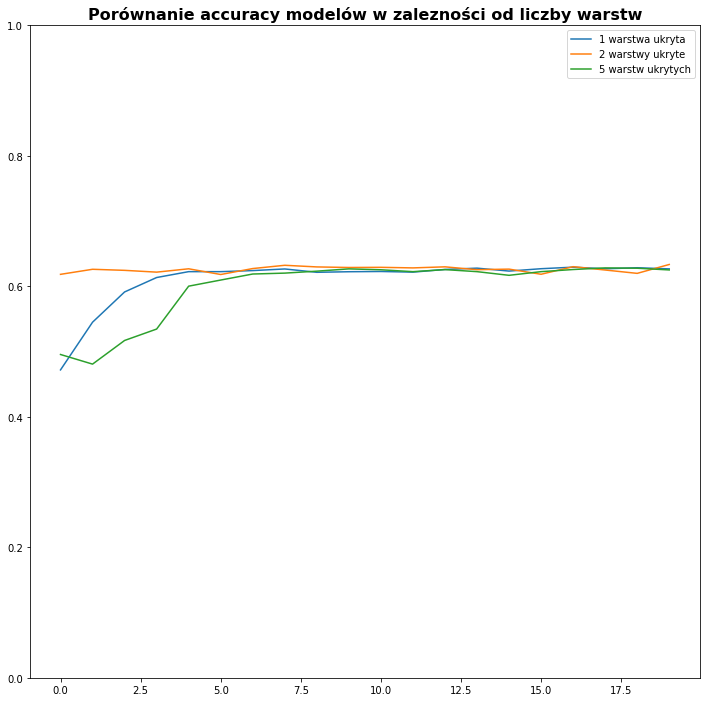

In [134]:
plt.figure(figsize=(12, 12))
plt.plot(modelfitted.history['accuracy'], label="1 warstwa ukryta")
plt.plot(model1fitted.history['accuracy'], label="2 warstwy ukryte")
plt.plot(model2fitted.history['accuracy'], label="5 warstw ukrytych")
plt.title("Porównanie accuracy modelów w zalezności od liczby warstw", fontdict={"fontweight": "bold", "size": 16})
plt.legend()
plt.ylim(0, 1)

Wyniki dokładności modelów

In [136]:
model.evaluate(X_test, y_test)
model1.evaluate(X_test, y_test)
model2.evaluate(X_test, y_test)

63/63 [==============================] - 0s 3ms/step - loss: 0.7904 - accuracy: 0.6100


[0.7904057502746582, 0.6100000143051147]